### In this file, I will use the completed clincial trials data to train two machine learning model to predict the clincial trials' outcome.

In [5]:
# import the packages needed in this file
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout
from kerastuner.tuners import RandomSearch

In [6]:
# Allow the dataframe to show all columns
pd.set_option('display.max_columns', None)

In [7]:
# Import the data and show the dataframe
completed_trial=pd.read_csv('completed_trial.csv', index_col=False)
completed_trial

,nct_id,description,downcase_mesh_term,interventions_mesh_term,countries_name,detailed_description,gender,minimum_age,maximum_age,criteria,facility_name,city,state,country,contact_name,email,phone,phone_extension,keywords,agency_class,agency_name,study_type,official_title,overall_status,phase,source,number_of_arms,is_fda_regulated_drug,is_fda_regulated_device,intervention_type,drug_name
0,NCT00000105,The purpose of this study is to learn how the ...,"tetanus, clostridium infections, gram-positive...","monatide (ims 3015), freund's adjuvant, adjuva...",United States,Patients will receive each vaccine once only c...,All,18 Years,120 Years,Inclusion Criteria:~Patients must have a diagn...,"Division of Hematology, Oncology, and Transpla...",Minneapolis,Minnesota,United States,unknown,unknown,unknown,unknown,n.a,OTHER,"Masonic Cancer Center, University of Minnesota",Observational,Vaccination With Tetanus Toxoid and Keyhole Li...,0,unknown,"Masonic Cancer Center, University of Minnesota",unknown,unknown,unknown,"Biological, Drug","Intracel KLH Vaccine, Biosyn KLH, Montanide IS..."
1,NCT00000113,To evaluate whether progressive addition lense...,"myopia, refractive errors, eye diseases",n.a,United States,Myopia (nearsightedness) is an important publi...,All,6 Years,12 Years,Children between the ages of 6 and 12 years wi...,"University of Alabama-Birmingham, School of Op...","Birmingham, Boston, Philadelphia, Houston","Alabama, Massachusetts, Pennsylvania, Texas",United States,unknown,unknown,unknown,unknown,"myopia, nearsightedness","OTHER, NIH","Stony Brook University, National Eye Institute...",Interventional,Correction of Myopia Evaluation Trial (COMET),1,Phase 3,Stony Brook University,2.0,unknown,unknown,Other,"Progressive Addition Lenses, single vision lenses"
2,NCT00000116,The purpose of this trial is to determine whet...,"retinitis, retinitis pigmentosa, retinal disea...","vitamin a, vitamins, micronutrients, physiolog...",United States,Retinitis pigmentosa (RP) is a group of inheri...,All,18 Years,55 Years,Inclusion Criteria:~Ocular Criteria:~Retinitis...,Berman-Gund Laboratory for the Study of Retina...,Boston,Massachusetts,United States,unknown,unknown,unknown,unknown,n.a,NIH,Carol Weigel DiFranco,Interventional,Clinical Trial of Docosahexaenoic Acid (DHA) i...,1,Phase 3,National Eye Institute (NEI),2.0,unknown,unknown,Dietary Supplement,"Vitamin A, Docosahexaenoic acid, Control fatty..."
3,NCT00000143,"To compare the newest CMV retinitis drug, cido...","cytomegalovirus retinitis, retinitis, infectio...","ganciclovir, ganciclovir triphosphate, cidofov...",United States,Cytomegalovirus (CMV) is among the most freque...,All,13 Years,120 Years,Inclusion criteria:~Age 13 years or older~Diag...,"Department of Ophthalmology, University of Cal...","Irvine, La Jolla, Los Angeles, San Francisco, ...","California, Florida, Georgia, Illinois, Indian...",United States,unknown,unknown,unknown,unknown,n.a,OTHER,Johns Hopkins Bloomberg School of Public Health,Interventional,Studies of Ocular Complications of AIDS (SOCA)...,1,Phase 3,Johns Hopkins Bloomberg School of Public Health,2.0,unknown,unknown,"Device, Drug","Ganciclovir implant and oral ganciclovir, Cido..."
4,NCT00000167,To determine whether application of low-intens...,"macular degeneration, retinal degeneration, re...",n.a,United States,Complications of age-related macular degenerat...,All,50 Years,120 Years,Patients eligible for CAPT can be either male ...,"Retinal Consultants of Arizona, Ltd., West Coa...","Mesa, Peoria, San Francisco, Tampa, Atlanta, C...","Arizona, California, Florida, Georgia, Illinoi...",United States,unknown,unknown,unknown,unknown,age-related macular degeneration,NIH,National Eye Institute (NEI),Interventional,Complications of Age-Related Macular Degenerat...,1,Phase 3,National Eye Institute (NEI),1.0,unknown,unknown,Procedure,Low-Intensity Laser Treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [8]:
#Check empty value exist
null_counts = completed_trial.isnull().sum()
null_counts

nct_id                          0
description                     0
downcase_mesh_term              0
interventions_mesh_term         0
countries_name                  1
detailed_description            0
gender                          0
minimum_age                     0
maximum_age                     0
criteria                        0
facility_name                7602
city                           14
state                      109299
country                        14
contact_name                    0
email                           0
phone                           0
phone_extension                 0
keywords                        0
agency_class                    0
agency_name                     0
study_type                      0
official_title                  0
overall_status                  0
phase                           0
source                          0
number_of_arms                  0
is_fda_regulated_drug           0
is_fda_regulated_device         0
intervention_t

In [9]:
# Delete the row contain empty value. The state and facility name columns will not be used in the machine learning; therefore, I can keep it
completed_trial = completed_trial.dropna(subset=['country'])
completed_trial = completed_trial.dropna(subset=['drug_name'])
null_counts = completed_trial.isnull().sum()
null_counts

nct_id                          0
description                     0
downcase_mesh_term              0
interventions_mesh_term         0
countries_name                  0
detailed_description            0
gender                          0
minimum_age                     0
maximum_age                     0
criteria                        0
facility_name                7600
city                            0
state                      109261
country                         0
contact_name                    0
email                           0
phone                           0
phone_extension                 0
keywords                        0
agency_class                    0
agency_name                     0
study_type                      0
official_title                  0
overall_status                  0
phase                           0
source                          0
number_of_arms                  0
is_fda_regulated_drug           0
is_fda_regulated_device         0
intervention_t

In [10]:
# Check the outcome of clincial trials are binary or not
unique_values = completed_trial['overall_status'].unique()
unique_values

array([0, 1], dtype=int64)

In [11]:
# Make a copy of dataframe so that the following operation will not affect the orignal data
completed_trial_copy=completed_trial.copy()

In [12]:
# Check the expression style of age
unique_values = completed_trial_copy['maximum_age'].unique()
unique_values

array(['120 Years', '12 Years', '55 Years', '6 Years', '90 Years',
       '47 Years', '51 Years', '49 Years', '45 Years', '65 Years',
       '50 Years', '41 Years', '60 Years', '43 Years', '48 Years',
       '37 Years', '32 Years', '29 Years', '34 Years', '39 Years',
       '99 Years', '64 Years', '62 Years', '57 Years', '59 Years',
       '70 Years', '40 Years', '80 Years', '95 Years', '14 Years',
       '16 Years', '17 Years', '19 Years', '85 Years', '13 Years',
       '10 Years', '4 Years', '75 Years', '27 Years', '18 Years',
       '72 Years', '79 Years', '5 Years', '69 Years', '2 Years',
       '9 Months', '8 Years', '3 Days', '20 Years', '18 Months',
       '7 Months', '6 Months', '5 Days', '28 Days', '17 Days', '15 Years',
       '21 Years', '3 Months', '22 Years', '1 Month', '100 Years',
       '42 Years', '35 Years', '110 Years', '30 Years', '71 Years',
       '3 Years', '11 Years', '74 Years', '78 Years', '25 Years',
       '9 Years', '1 Year', '76 Years', '44 Years', '54 Yea

In [13]:
#Since the age has been expressed in Years, Months, Weeks, Days, Hours, I write a function to transform the age unit into years.
def convert_to_years(age_str):
    """This function will transform the time's unit from Months, Weeks, Days, Hours into Years """
    num = float(age_str.split()[0])
    if 'Year' in age_str:
        return num
    elif 'Month' in age_str:
        return num / 12  
    elif 'Week' in age_str:
        return num / 52  
    elif 'Day' in age_str:
        return num / 365  
    elif 'Hour' in age_str:
        return num / (365 * 24) 
    else:
        return 0

In [14]:
# Convert the minimum_age and maximum_age unit into years
completed_trial_copy['minimum_age'] = completed_trial_copy['minimum_age'].apply(convert_to_years)
completed_trial_copy['maximum_age'] = completed_trial_copy['maximum_age'].apply(convert_to_years)
completed_trial_copy

,nct_id,description,downcase_mesh_term,interventions_mesh_term,countries_name,detailed_description,gender,minimum_age,maximum_age,criteria,facility_name,city,state,country,contact_name,email,phone,phone_extension,keywords,agency_class,agency_name,study_type,official_title,overall_status,phase,source,number_of_arms,is_fda_regulated_drug,is_fda_regulated_device,intervention_type,drug_name
0,NCT00000105,The purpose of this study is to learn how the ...,"tetanus, clostridium infections, gram-positive...","monatide (ims 3015), freund's adjuvant, adjuva...",United States,Patients will receive each vaccine once only c...,All,18.0,120.0,Inclusion Criteria:~Patients must have a diagn...,"Division of Hematology, Oncology, and Transpla...",Minneapolis,Minnesota,United States,unknown,unknown,unknown,unknown,n.a,OTHER,"Masonic Cancer Center, University of Minnesota",Observational,Vaccination With Tetanus Toxoid and Keyhole Li...,0,unknown,"Masonic Cancer Center, University of Minnesota",unknown,unknown,unknown,"Biological, Drug","Intracel KLH Vaccine, Biosyn KLH, Montanide IS..."
1,NCT00000113,To evaluate whether progressive addition lense...,"myopia, refractive errors, eye diseases",n.a,United States,Myopia (nearsightedness) is an important publi...,All,6.0,12.0,Children between the ages of 6 and 12 years wi...,"University of Alabama-Birmingham, School of Op...","Birmingham, Boston, Philadelphia, Houston","Alabama, Massachusetts, Pennsylvania, Texas",United States,unknown,unknown,unknown,unknown,"myopia, nearsightedness","OTHER, NIH","Stony Brook University, National Eye Institute...",Interventional,Correction of Myopia Evaluation Trial (COMET),1,Phase 3,Stony Brook University,2.0,unknown,unknown,Other,"Progressive Addition Lenses, single vision lenses"
2,NCT00000116,The purpose of this trial is to determine whet...,"retinitis, retinitis pigmentosa, retinal disea...","vitamin a, vitamins, micronutrients, physiolog...",United States,Retinitis pigmentosa (RP) is a group of inheri...,All,18.0,55.0,Inclusion Criteria:~Ocular Criteria:~Retinitis...,Berman-Gund Laboratory for the Study of Retina...,Boston,Massachusetts,United States,unknown,unknown,unknown,unknown,n.a,NIH,Carol Weigel DiFranco,Interventional,Clinical Trial of Docosahexaenoic Acid (DHA) i...,1,Phase 3,National Eye Institute (NEI),2.0,unknown,unknown,Dietary Supplement,"Vitamin A, Docosahexaenoic acid, Control fatty..."
3,NCT00000143,"To compare the newest CMV retinitis drug, cido...","cytomegalovirus retinitis, retinitis, infectio...","ganciclovir, ganciclovir triphosphate, cidofov...",United States,Cytomegalovirus (CMV) is among the most freque...,All,13.0,120.0,Inclusion criteria:~Age 13 years or older~Diag...,"Department of Ophthalmology, University of Cal...","Irvine, La Jolla, Los Angeles, San Francisco, ...","California, Florida, Georgia, Illinois, Indian...",United States,unknown,unknown,unknown,unknown,n.a,OTHER,Johns Hopkins Bloomberg School of Public Health,Interventional,Studies of Ocular Complications of AIDS (SOCA)...,1,Phase 3,Johns Hopkins Bloomberg School of Public Health,2.0,unknown,unknown,"Device, Drug","Ganciclovir implant and oral ganciclovir, Cido..."
4,NCT00000167,To determine whether application of low-intens...,"macular degeneration, retinal degeneration, re...",n.a,United States,Complications of age-related macular degenerat...,All,50.0,120.0,Patients eligible for CAPT can be either male ...,"Retinal Consultants of Arizona, Ltd., West Coa...","Mesa, Peoria, San Francisco, Tampa, Atlanta, C...","Arizona, California, Florida, Georgia, Illinoi...",United States,unknown,unknown,unknown,unknown,age-related macular degeneration,NIH,National Eye Institute (NEI),Interventional,Complications of Age-Related Macular Degenerat...,1,Phase 3,National Eye Institute (NEI),1.0,unknown,unknown,Procedure,Low-Intensity Laser Treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314993,NCT06

In [15]:
#Check the result
unique_values = completed_trial_copy['minimum_age'].unique()
unique_values

array([1.80000000e+01, 6.00000000e+00, 1.30000000e+01, 5.00000000e+01,
       0.00000000e+00, 5.50000000e+01, 6.50000000e+01, 2.80000000e+01,
       2.10000000e+01, 2.50000000e+01, 2.60000000e+01, 1.90000000e+01,
       3.30000000e+01, 2.00000000e+01, 3.00000000e+01, 2.20000000e+01,
       3.40000000e+01, 2.30000000e+01, 3.10000000e+01, 1.40000000e+01,
       1.60000000e+01, 6.00000000e+01, 8.00000000e+00, 9.00000000e+00,
       1.50000000e+01, 4.00000000e+01, 4.50000000e+01, 5.00000000e+00,
       3.00000000e+00, 4.60000000e+01, 1.00000000e+00, 1.20000000e+01,
       1.66666667e-01, 2.50000000e-01, 2.73972603e-03, 8.33333333e-02,
       7.67123288e-02, 3.83561644e-02, 5.00000000e-01, 2.00000000e+00,
       4.10958904e-02, 3.33333333e-01, 4.00000000e+00, 1.50000000e+00,
       7.00000000e+00, 1.70000000e+01, 1.00000000e+01, 1.58333333e+00,
       7.00000000e+01, 4.80000000e+01, 6.10000000e+01, 3.50000000e+01,
       5.60000000e+01, 2.90000000e+01, 7.50000000e+01, 1.10000000e+01,
      

In [16]:
#Check the the data type of minimum_age
column_type = completed_trial_copy['minimum_age'].dtype
column_type

dtype('float64')

In [17]:
#Check the the data type of maximum_age
column_type = completed_trial_copy['maximum_age'].dtype
column_type

dtype('float64')

### Check the unique value of columns and decide which type of encoder will be use

In [18]:
unique_values = completed_trial_copy['study_type'].unique()
unique_values

array(['Observational', 'Interventional',
       'Observational [Patient Registry]', 'Expanded Access'],
      dtype=object)

In [19]:
unique_values = completed_trial_copy['gender'].unique()
unique_values

array(['All', 'Female', 'Male'], dtype=object)

In [20]:
unique_values = completed_trial_copy['phase'].unique()
unique_values

array(['unknown', 'Phase 3', 'Phase 2', 'Phase 1', 'Phase 4',
       'Not Applicable', 'Phase 1/Phase 2', 'Phase 2/Phase 3',
       'Early Phase 1'], dtype=object)

In [21]:
unique_values = completed_trial_copy['number_of_arms'].unique()
unique_values

array(['unknown', '2.0', '1.0', '4.0', '6.0', '5.0', '3.0', '7.0', '15.0',
       '9.0', '10.0', '8.0', '13.0', '12.0', '16.0', '11.0', '14.0',
       '17.0', '19.0', '20.0', '32.0', '18.0', '22.0', '27.0', '24.0',
       '23.0', '28.0', '21.0', '25.0', '29.0', '30.0', '31.0', '26.0',
       '44.0', '40.0'], dtype=object)

In [22]:
unique_values = completed_trial_copy['is_fda_regulated_drug'].unique()
unique_values

array(['unknown', 'f', 't'], dtype=object)

In [23]:
unique_values = completed_trial_copy['is_fda_regulated_device'].unique()
unique_values

array(['unknown', 'f', 't'], dtype=object)

In [24]:
unique_values = completed_trial_copy['agency_class'].unique()
unique_values

array(['OTHER', 'OTHER, NIH', 'NIH', 'INDUSTRY', 'NIH, OTHER',
       'OTHER, NIH, FED', 'NIH, FED', 'OTHER, NIH, INDUSTRY',
       'OTHER, NIH, UNKNOWN', 'FED, NIH', 'OTHER, NIH, NETWORK',
       'NIH, INDUSTRY', 'INDUSTRY, NIH', 'NIH, INDUSTRY, UNKNOWN',
       'NETWORK, NIH', 'UNKNOWN', 'INDUSTRY, FED, OTHER', 'FED',
       'NETWORK', 'NETWORK, OTHER', 'OTHER_GOV',
       'NETWORK, NIH, OTHER_GOV', 'OTHER, OTHER_GOV',
       'NETWORK, NIH, OTHER', 'NETWORK, OTHER_GOV',
       'INDUSTRY, OTHER, NIH', 'NIH, NETWORK', 'OTHER_GOV, NETWORK',
       'OTHER, INDUSTRY', 'OTHER, NETWORK',
       'OTHER, NIH, NETWORK, INDUSTRY', 'OTHER, UNKNOWN, NIH',
       'NETWORK, INDUSTRY', 'NETWORK, NIH, INDUSTRY', 'OTHER, UNKNOWN',
       'OTHER, INDUSTRY, NIH', 'INDIV, NETWORK, OTHER',
       'NIH, UNKNOWN, OTHER, FED', 'INDUSTRY, NIH, OTHER',
       'NIH, INDUSTRY, NETWORK, UNKNOWN, OTHER',
       'NIH, OTHER, UNKNOWN, FED', 'NETWORK, NIH, OTHER_GOV, INDUSTRY',
       'NETWORK, OTHER, NIH', 'NIH, OTH

### The columns study_type,gender, phase, number_of_arms, is_fda_regulated_drug, is_fda_regulated_device have a few type of unique input which did not have hierarchy relationship therefore they will use encode by one hot encoder.

In [25]:
# Check the columns contain Null value
contains_none_downcase_mesh_term = completed_trial_copy['downcase_mesh_term'].isnull().any()
contains_none_interventions_mesh_term = completed_trial_copy['interventions_mesh_term'].isnull().any()
contains_none_criteria = completed_trial_copy['criteria'].isnull().any()
contains_none_facility_name = completed_trial_copy['facility_name'].isnull().any()
contains_none_country = completed_trial_copy['country'].isnull().any()
contains_none_keywords = completed_trial_copy['keywords'].isnull().any()
contains_none_agency_name = completed_trial_copy['agency_name'].isnull().any()
contains_none_source = completed_trial_copy['source'].isnull().any()
contains_none_intervention_type = completed_trial_copy['intervention_type'].isnull().any()
contains_none_drug_name = completed_trial_copy['drug_name'].isnull().any()
contains_none_agency_class = completed_trial_copy['agency_class'].isnull().any()

In [26]:
print(contains_none_downcase_mesh_term,contains_none_interventions_mesh_term,contains_none_criteria, contains_none_facility_name
,contains_none_country,contains_none_keywords,contains_none_agency_name,contains_none_source,contains_none_intervention_type
,contains_none_drug_name,contains_none_agency_class)

False False False True False False False False False False False


In [31]:
# Remove the irrelevant columns and split the dataframe into X and y
columns_to_drop = ['overall_status', 'nct_id', 'description','detailed_description','official_title','city','state','countries_name','contact_name',
                  'email','phone','phone_extension','official_title','facility_name']
X = completed_trial_copy.drop(columns_to_drop, axis=1)  
y = completed_trial_copy['overall_status'] 

In [32]:
#show x set
X

,downcase_mesh_term,interventions_mesh_term,gender,minimum_age,maximum_age,criteria,country,keywords,agency_class,agency_name,study_type,phase,source,number_of_arms,is_fda_regulated_drug,is_fda_regulated_device,intervention_type,drug_name
0,"tetanus, clostridium infections, gram-positive...","monatide (ims 3015), freund's adjuvant, adjuva...",All,18.0,120.0,Inclusion Criteria:~Patients must have a diagn...,United States,n.a,OTHER,"Masonic Cancer Center, University of Minnesota",Observational,unknown,"Masonic Cancer Center, University of Minnesota",unknown,unknown,unknown,"Biological, Drug","Intracel KLH Vaccine, Biosyn KLH, Montanide IS..."
1,"myopia, refractive errors, eye diseases",n.a,All,6.0,12.0,Children between the ages of 6 and 12 years wi...,United States,"myopia, nearsightedness","OTHER, NIH","Stony Brook University, National Eye Institute...",Interventional,Phase 3,Stony Brook University,2.0,unknown,unknown,Other,"Progressive Addition Lenses, single vision lenses"
2,"retinitis, retinitis pigmentosa, retinal disea...","vitamin a, vitamins, micronutrients, physiolog...",All,18.0,55.0,Inclusion Criteria:~Ocular Criteria:~Retinitis...,United States,n.a,NIH,Carol Weigel DiFranco,Interventional,Phase 3,National Eye Institute (NEI),2.0,unknown,unknown,Dietary Supplement,"Vitamin A, Docosahexaenoic acid, Control fatty..."
3,"cytomegalovirus retinitis, retinitis, infectio...","ganciclovir, ganciclovir triphosphate, cidofov...",All,13.0,120.0,Inclusion criteria:~Age 13 years or older~Diag...,United States,n.a,OTHER,Johns Hopkins Bloomberg School of Public Health,Interventional,Phase 3,Johns Hopkins Bloomberg School of Public Health,2.0,unknown,unknown,"Device, Drug","Ganciclovir implant and oral ganciclovir, Cido..."
4,"macular degeneration, retinal degeneration, re...",n.a,All,50.0,120.0,Patients eligible for CAPT can be either male ...,United States,age-related macular degeneration,NIH,National Eye Institute (NEI),Interventional,Phase 3,National Eye Institute (NEI),1.0,unknown,unknown,Procedure,Low-Intensity Laser Treatment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314993,"covid-19, heart diseases, heart defects, conge...",n.a,Female,20.0,48.0,"Inclusion Criteria:~Mothers, whose children un...",Taiwan,n.a,OTHER,Chung Shan Medical University,Interventional,Not Applicable,Chung Shan Medical University,2.0,f,f,Other,Preoperative educational videos plus routine e...
314994,"breast neoplasms, neoplasms by site, neoplasms...","trastuzumab, vinorelbine, antineoplastic agent...",Female,18.0,75.0,Inclusion Criteria:~1. Female ≥18 and ≤75 year...,China,n.a,INDUSTRY,Zhejiang Hisun Pharmaceutical Co. Ltd.,Interventional,Phase 3,Zhejiang Hisun Pharmaceutical Co. Ltd.,2.0,f,f,Drug,"HS022, Trastuzumab, Vinorelbine Bitartrate"
314995,n.a,n.a,All,30.0,59.0,Inclusion Criteria:~Participants were eligible...,United Kingdom,"activities of daily living, balance, independe...",OTHER,Northumbria University,Interventional,Not Applicable,Northumbria University,2.0,f,f,Other,Leg Press Resistance Training Machine
314996,"sleep wake disorders, parasomnias, dyssomnias,...",n.a,All,18.0,120.0,Inclusion Criteria:~Age 18 and older~Meets cri...,United States,n.a,"INDUSTRY, NIH","HealthRhythms, Inc., National Institutes of He...",Interventional,Not Applicable,"HealthRhythms, Inc.",2.0,f,f,Behavioral,CueToSleep (Full Intervention Package)


In [33]:
# Show the number of each label in training set.
y.value_counts()

overall_status
1    227917
0     86998
Name: count, dtype: int64

The result shows the label is imbalanced and I need to be careful about it when training the model

In [34]:
# I will use two encoder to encode my label, One hot encoder for those columns with limited amount of catergory. 
# TFIDF encoder was used to encode the columns with many different string content.
oh_cate = ['gender','study_type','phase','number_of_arms','is_fda_regulated_drug','is_fda_regulated_device','agency_class']
tfidf_cate= ['downcase_mesh_term','interventions_mesh_term','criteria','facility_name','country','keywords','agency_name','source',
             'intervention_type','drug_name']

In [35]:
# initialize the encoder
column_transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['gender','study_type','phase','number_of_arms',
                                                                                  'is_fda_regulated_drug','is_fda_regulated_device','agency_class']),
                                                     ('tfidf1', TfidfVectorizer(), 'downcase_mesh_term'),
                                                     ('tfidf2', TfidfVectorizer(), 'interventions_mesh_term'),
                                                     ('tfidf3', TfidfVectorizer(), 'criteria'),
                                                     ('tfidf4', TfidfVectorizer(), 'country'),
                                                     ('tfidf5', TfidfVectorizer(), 'keywords'),
                                                     ('tfidf6', TfidfVectorizer(), 'agency_name'),
                                                     ('tfidf7', TfidfVectorizer(), 'source'),
                                                     ('tfidf8', TfidfVectorizer(), 'intervention_type'),
                                                     ('tfidf9', TfidfVectorizer(), 'drug_name')],
                                                       remainder='passthrough')

In [36]:
# Apply the encoder
X_transform = column_transformer.fit_transform(X)

In [37]:
# Save the encoder for the ongoing dataset usage
joblib.dump(column_transformer, 'column_transformer.joblib')

['column_transformer.joblib']

In [69]:
# Split the training, testing, and validation dataset
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [101]:
# Display the splited dataset
X_train

<188949x366439 sparse matrix of type '<class 'numpy.float64'>'
	with 28963274 stored elements in Compressed Sparse Row format>

In [40]:
X_test

<62983x366439 sparse matrix of type '<class 'numpy.float64'>'
	with 9671366 stored elements in Compressed Sparse Row format>

In [41]:
y_train

275847    1
178610    1
125662    1
192965    1
124716    1
         ..
122360    0
129381    1
13048     0
230129    0
47337     1
Name: overall_status, Length: 188949, dtype: int64

In [42]:
y_test

157282    1
74727     1
18604     1
254683    1
20394     1
         ..
301521    1
57791     1
160036    1
59617     1
236733    0
Name: overall_status, Length: 62983, dtype: int64

In [43]:
X_val

<62983x366439 sparse matrix of type '<class 'numpy.float64'>'
	with 9677705 stored elements in Compressed Sparse Row format>

In [44]:
y_val

143672    0
21121     1
207138    0
160887    0
103493    1
         ..
1638      1
171743    1
224759    0
215929    0
298645    1
Name: overall_status, Length: 62983, dtype: int64

## XGboost model training

In [41]:
# Initialize a XGBoost model
xgb_model = XGBClassifier(tree_method='hist',device='cuda')

In [42]:
# Choose the range of parameters
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    }

In [43]:
# Intialize the randomized search grid
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=25, scoring='accuracy', cv=3, random_state=42)

In [44]:
# Train the XGboost Model
random_search.fit(X_train, y_train)

C:\Users\Buwei He\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [03:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=25,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='accuracy')

In [45]:
# Print out the best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05}


### Test model in val set

In [46]:
# Setup the best parameter for XGboost model
xgboost_model = random_search.best_estimator_

In [47]:
# Use validation set to test the model
y_val_pred = xgboost_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

In [48]:
print("Validation set score:", val_accuracy)

Validation set score: 0.7463760062239017


### Test model in test set and evaluation the performance

In [99]:
# Save the model
xgboost_model= joblib.load('xgboost_model.joblib')

In [100]:
# Make predication use XGboost
y_pred = xgboost_model.predict(X_test)

C:\Users\Buwei He\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [102]:
# Calucalte the performance of the model
accuracy_xgboost = accuracy_score(y_test, y_pred)
precision_xgboost = precision_score(y_test, y_pred)
recall_xgboost = recall_score(y_test, y_pred)
f1_xgboost = f1_score(y_test, y_pred)
cm_xgboost = confusion_matrix(y_test, y_pred)

In [103]:
accuracy_xgboost

0.7443595890954702

In [104]:
precision_xgboost

0.7520854072980674

In [105]:
recall_xgboost

0.9635623969213853

In [106]:
f1_xgboost

0.8447901905780965

In [107]:
print(classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.65      0.18      0.28     17508
           1       0.75      0.96      0.84     45475

    accuracy                           0.74     62983
   macro avg       0.70      0.57      0.56     62983
weighted avg       0.72      0.74      0.69     62983



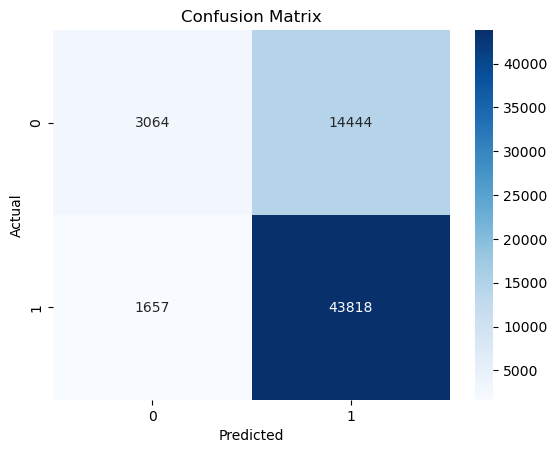

In [67]:
# Visulize the confusion matrix
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
joblib.dump(xgboost_model, 'xgboost_model.joblib')

['xgboost_model.joblib']

# Build up a neutral network model

In [76]:
# Re-shape the y data type that could fit into the neutral network
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [77]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [78]:
# Initialize the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input',  
                                 min_value=32, 
                                 max_value=512, 
                                 step=32), 
                    input_dim=X_train.shape[1], 
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_input',
                                    min_value=0.0,
                                    max_value=0.5,
                                    default=0.25,
                                    step=0.05)))
    
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(Dense(units=hp.Int('units_hidden_' + str(i),
                                     min_value=32,
                                     max_value=512,
                                     step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_hidden_' + str(i),
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.25,
                                        step=0.05)))
        
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', 
                                          min_value=1e-4, 
                                          max_value=1e-2, 
                                          sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [81]:
# Setup the range to fine tuning hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='/mnt/data/tuner_results', 
    project_name='keras_tuner_demo')

Reloading Tuner from /mnt/data/tuner_results\keras_tuner_demo\tuner0.json


In [82]:
# Train the model
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 4 Complete [05h 32m 50s]
val_accuracy: 0.742216169834137

Best val_accuracy So Far: 0.742216169834137
Total elapsed time: 1d 01h 19m 59s


In [83]:
# Build up the model with the best parameters
best_model_nn = tuner.get_best_models(num_models=1)[0]

In [84]:
# Make predication using the testing dataset
predictions = best_model_nn.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

1969/1969 [==============================] - 4s 2ms/step


In [85]:
y_test

157282    1
74727     1
18604     1
254683    1
20394     1
         ..
301521    1
57791     1
160036    1
59617     1
236733    0
Name: overall_status, Length: 62983, dtype: int64

In [92]:
# Calculate the performance score
accuracy_nn = accuracy_score(y_test, predicted_labels)
precision_nn = precision_score(y_test, predicted_labels)
recall_nn = recall_score(y_test, predicted_labels)
f1_nn = f1_score(y_test, predicted_labels)
cm_nn = confusion_matrix(y_test, predicted_labels)

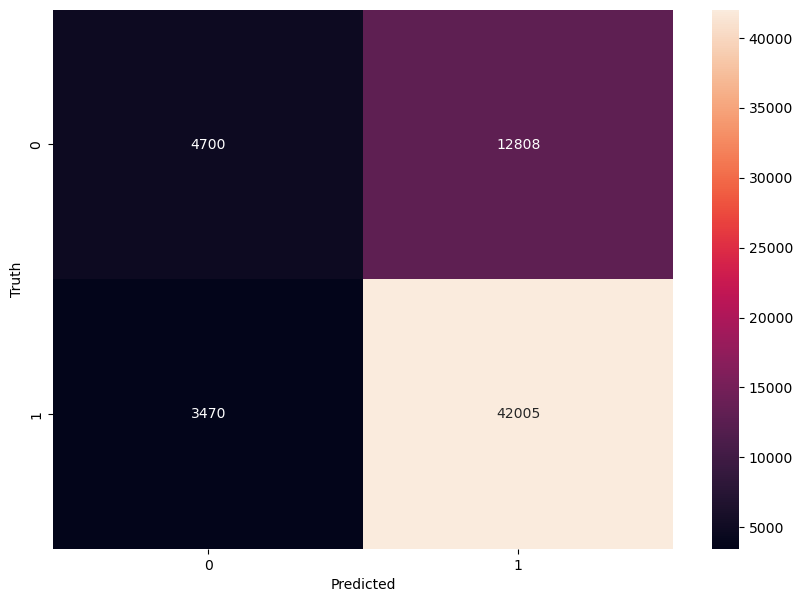

In [87]:
# Visulize the confusion matrix
ns.heatmap(cm_nn, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [93]:
accuracy_nn

0.7415493069558452

In [75]:
best_model_nn.save('best_model_nn.keras')

# Compare two models

In [108]:
print (accuracy_xgboost,  ' vs ' ,accuracy_nn)

0.7443595890954702  vs  0.7415493069558452


In [109]:
print (precision_xgboost,  ' vs ' ,precision_nn)

0.7520854072980674  vs  0.7663328042617628


In [110]:
print (recall_xgboost,  ' vs ' ,recall_nn)

0.9635623969213853  vs  0.9236943375481034


In [111]:
print (f1_xgboost,  ' vs ' ,f1_nn)

0.8447901905780965  vs  0.8376874601148692


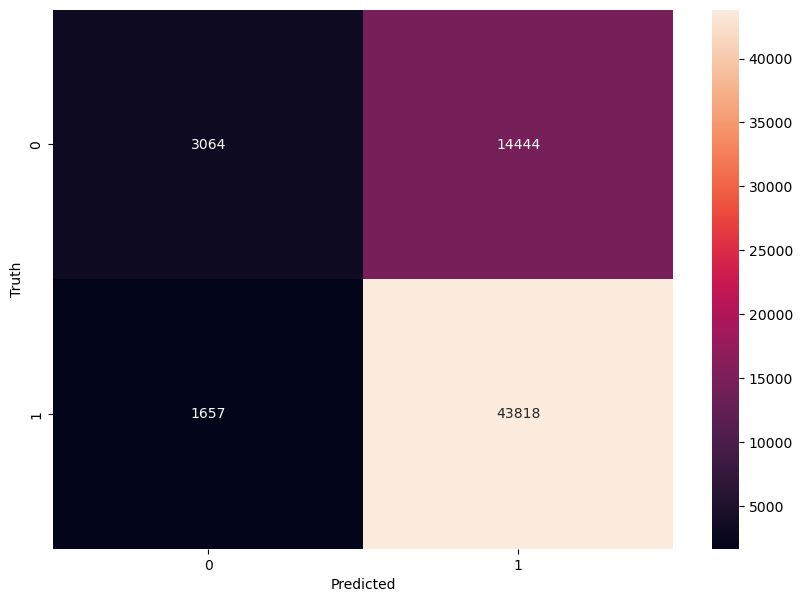

In [112]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgboost, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

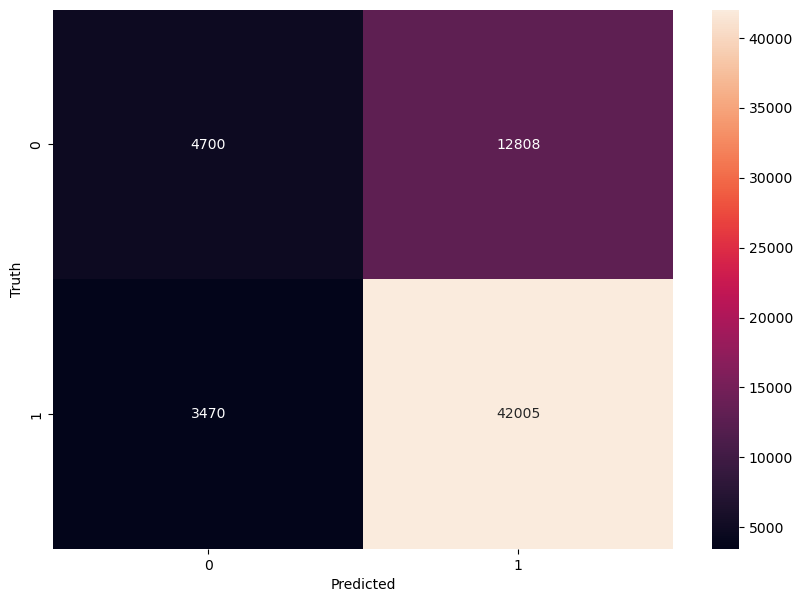

In [113]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nn, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

This two models overall has very similar performance. No matter the accurate, precision, recall and F1 score, those two matrix were nearly identifical. From the confusion matrix, the XGboost has slightly higer False positive rate comparing to the neutral network model. In clinical trial, the false positive has significant higher influence compared to false negative. Therefore, the neutral network model will be used in predicting the ongoing clinical trial.